<a href="https://colab.research.google.com/github/GiorgosMaragkopoulos/Quantum-data-encoding-using-QAE-PQAE/blob/main/WINES_QKPCA_Data_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA-embedded quantum autoencoder (PQAE) for encoding the WINES dataset in a variational quantum circuit (VQC)

In this jupyter notebook, I present the implementation of a PCA Quantum autoencoder (PQAE), which is used to encode data into a qiskit VQC. PQAE is a novel encoding approach for classical to quantum data. The original data get reduced through an autoencoder which has a quantum feature map in the middle, which is used as a kernel for Kernel PCA. This reduced space is then decoded back to the original, and the reconstruction loss is optimized.

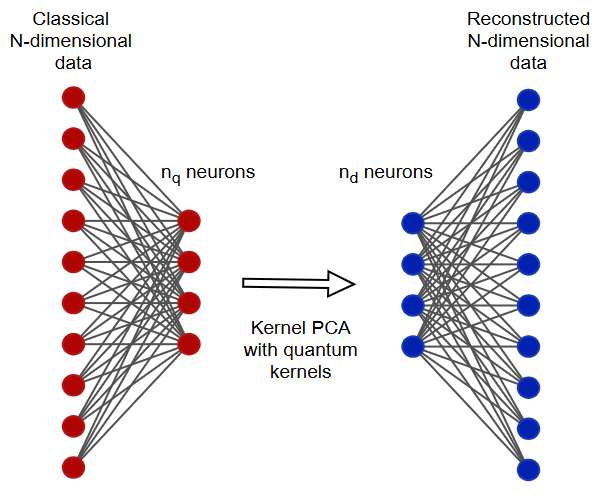

There will be a comparison between the performance of the VQC with the PQAE encoding VS without it. The dataset in this example is going to be the iris dataset, which is a three class, classification problem.

In [1]:
%%capture
!pip install qiskit_algorithms
!pip install qiskit_machine_learning

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.decomposition import KernelPCA
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
import random
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap,RealAmplitudes
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import COBYLA
import copy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA


## Set a random seed for reproducibility

In [3]:
# Function to set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    algorithm_globals.random_seed = seed


# Set seeds
set_seed(2)

## WINES dataset

Each sample in the wines dataset contains information about the petal and sepal length and width. The goal of this classification task is to predict the three types of flowers, based on these values.

In [4]:
from sklearn.datasets import load_wine
wine_data = load_wine()

In [5]:
features = wine_data.data
labels = wine_data.target

In [6]:
features.shape

(178, 13)

In [7]:
features = MinMaxScaler().fit_transform(features)

We split the data in three sets (train-val-test) with a (70%-10%-20%) split. The validation split is going to be needed for the PQAE part and not for the PCA part. Nonetheless, we make the split from now, so that the train and test datasets will be the same.


In [8]:
train_size = 125
val_size = 17
test_size = 36


train_features, remaining_features, train_labels, remaining_labels = train_test_split(
    features, labels, train_size=train_size, random_state=algorithm_globals.random_seed
)

val_features, test_features, val_labels, test_labels = train_test_split(
    remaining_features, remaining_labels, test_size=test_size, random_state=algorithm_globals.random_seed
)

# SVC training for comparison reasons

We train a classical Support Vector Classifier from scikit-learn. For the sake of simplicity, we don't tweak any parameters and rely on the default values.

In [9]:
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

Now we check out how well our classical model performs. We will analyze the scores in the conclusion section.

In [10]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     1.00


# Raw/PCA qiskit

Here we are going to use the raw data, before passing them in the VQC.

## VQC set up

To set up the components for the VQC model, we utilize a ZZFeatureMap for quantum feature mapping, RealAmplitudes as the ansatz function, and the COBYLA optimizer. The feature map is created according to the dimensions of the input data, while the ansatz function is configured with three repetitions.

The COBYLA optimizer is configured to perform up to 100 iterations. The dataset is then split into training and test sets with an 80-20 ratio using the train_test_split function, ensuring consistency with a fixed random seed. Together, these components configure the VQC model and prepare the dataset for both training and evaluation.

In [11]:
num_features = 4

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

The RealAmplitudes ansatz will have 3 reps

In [12]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [13]:
q_optimizer = COBYLA(maxiter=100)

In [14]:
sampler = Sampler()

<ipython-input-14-afb98dbeff78>:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [15]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [16]:
pca = PCA(n_components=4)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)


The VQC is ran here

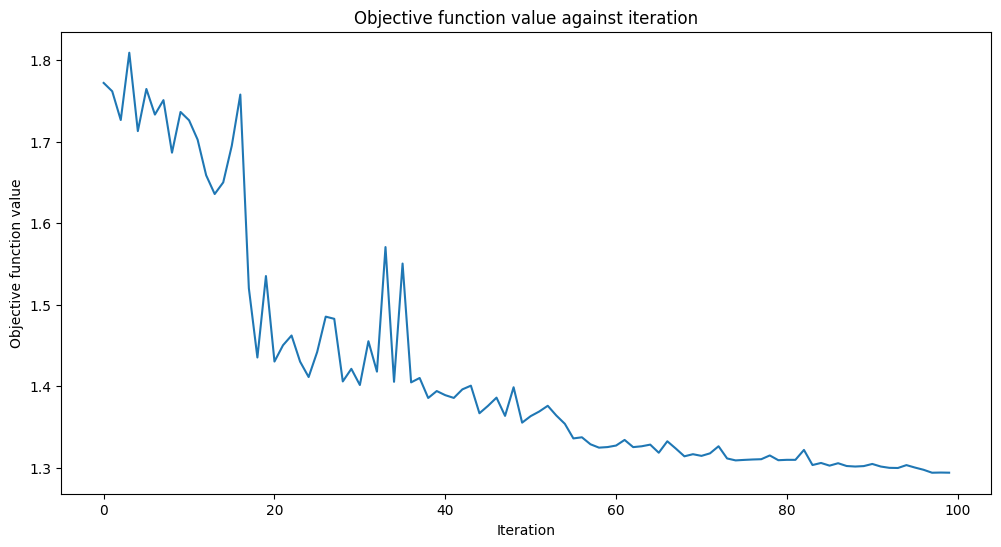

Training time: 120 seconds


In [17]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=q_optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features_pca, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Let's see how the quantum model performs on the real-life dataset.

In [18]:
train_score_q4 = vqc.score(train_features_pca, train_labels)
test_score_q4 = vqc.score(test_features_pca, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.62
Quantum VQC on the test dataset:     0.56


#  PCA Quantum Autoencoder

Now we will present and implement our novel data encoding algorithm called PQAE. Because we intend to use 4 qubits, and the number of features in iris is 4, we will start with an encoder which is 4x4 (the connection of input to hidden layers). Then, these values are going to be passed through the featue map and kernel PCA will be used to reduce the dimensionality to 4. Then, a 4x4 decoding generates the output. This type of network encodes the classical data to 4 qubits.  

The PQAE class is equipped with a sampler, which samples from the quantum circuit. The fidelity is estimated using the compute-uncompute technique. The feature map is the ZZFeatureMap with the number of reps being decided as a parameter. The kernel matrix is calculated using the FidelityQuantumKernel for quantum data using the fidelity metric. KernelPCA is fitted on the precomputed kernel matrix and transform the training data. This step reduces the dimensionality of the training data to the specified number of components. After that, linear decoding layers reconstruct the data back to their original form.

In [19]:

# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size =20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(torch.tensor(np.array(train_features) ), batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(torch.tensor(np.array(val_features) ), batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(torch.tensor(np.array(test_features) ), batch_size=batch_size, num_workers=num_workers)

In [20]:
# Fetch a single <1MB file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/GiorgosMaragkopoulos/Quantum-data-encoding-using-QAE-PQAE/main/PQAE_class.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4335  100  4335    0     0  11838      0 --:--:-- --:--:-- --:--:-- 11844


In [21]:
from PQAE_class import PQAE

After defining the PQAE class, we need to optimize the PQAE using mean squared error as our loss function and Adam optimizer.

In [22]:
input_dim = train_features.shape[1]

pqae = PQAE(input_dim=input_dim,n_qubits=4,n_pca=4)

criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(pqae.parameters(), lr=0.001)

# number of epochs to train the pqae model
n_epochs = 5

best_pqae = copy.deepcopy(pqae)  # Initialize the best pqae model with the current one
best_val_loss = float('inf')  # Initialize with a high value

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0

    ###################
    # train the model #
    ###################
    pqae.train()
    for data in train_loader:
        optimizer.zero_grad()
        outputs = pqae(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # print avg training statistics
    train_loss = train_loss / len(train_loader)

    ######################
    # validate the model #
    ######################
    pqae.eval()
    for data in val_loader:
        outputs = pqae(data)
        loss = criterion(outputs, data)
        val_loss += loss.item() * data.size(0)

    # print avg validation statistics
    val_loss = val_loss / len(val_loader)

    print("Epoch", epoch)
    print("Train Loss:", train_loss)
    print("Validation Loss:", val_loss)

    # Check if the current model has a lower validation error
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_pqae = copy.deepcopy(pqae)

Epoch 1
Train Loss: 8.185943914796802
Validation Loss: 8.26868191123239
Epoch 2
Train Loss: 8.03185526319378
Validation Loss: 8.11931857344089
Epoch 3
Train Loss: 7.8808701729863575
Validation Loss: 7.972290518031134
Epoch 4
Train Loss: 7.732454603740615
Validation Loss: 7.827727385260754
Epoch 5
Train Loss: 7.586662281270966
Validation Loss: 7.685700267783849


Then we generate the data, before passing them in the VQC.


In [23]:
# Initialize pandas DataFrames to store predictions
train_predictions_df = pd.DataFrame()
test_predictions_df = pd.DataFrame()

# monitor training loss
train_loss = 0.0
test_loss = 0.0

###################
# train the model #
###################
best_pqae.train()
for data in train_loader:
    optimizer.zero_grad()
    outputs = best_pqae.forward_2(data)
    train_loss += loss.item() * data.size(0)

    # Append predictions to train_predictions_df
    train_predictions_df = pd.concat([train_predictions_df, pd.DataFrame(outputs.detach().numpy())])

######################
# test the model #
######################
best_pqae.eval()
for data in test_loader:
    outputs = best_pqae.forward_2(data)


    # Append predictions to test_predictions_df
    test_predictions_df = pd.concat([test_predictions_df, pd.DataFrame(outputs.detach().numpy())])


In [24]:
q_optimizer = COBYLA(maxiter=100)

The same VQC structure is used, but now the data have been optimized to keep the outmost information after the encoding.

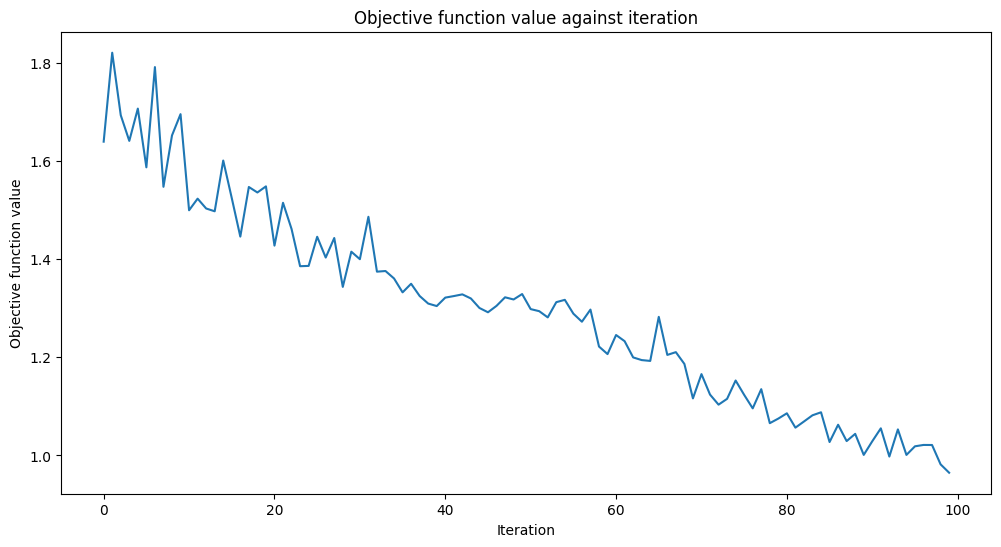

In [25]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=q_optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_predictions_df, train_labels)
elapsed = time.time() - start

In [26]:
train_score_q4 = vqc.score(train_predictions_df, train_labels)
test_score_q4 = vqc.score(test_predictions_df, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.89
Quantum VQC on the test dataset:     0.78


It turns out that the best performing model after encoding the data through PQAE is 90%. Greatly outperforming the raw encoding one which was 85%